In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import yaml
import pickle
import os
import time

from utils.generate_data import *
from utils.sub_sampler import *
from utils.compute_barycenter import *
from utils.general_utils import *

data_path = 'data'

### Paper's Gaussian mixture experiment

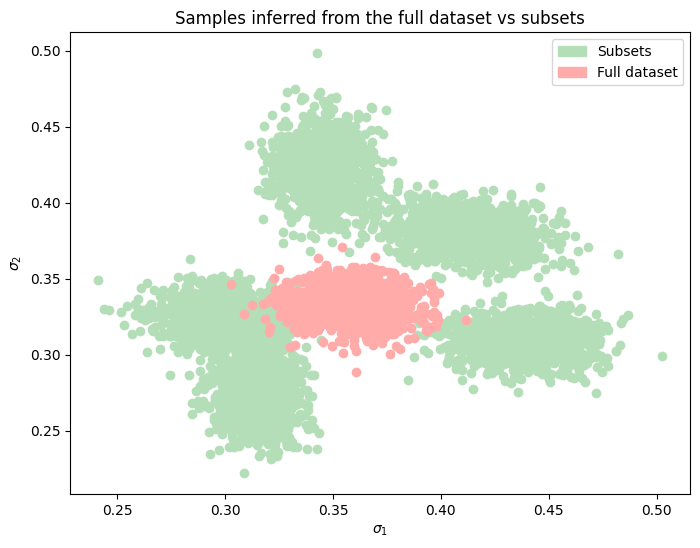

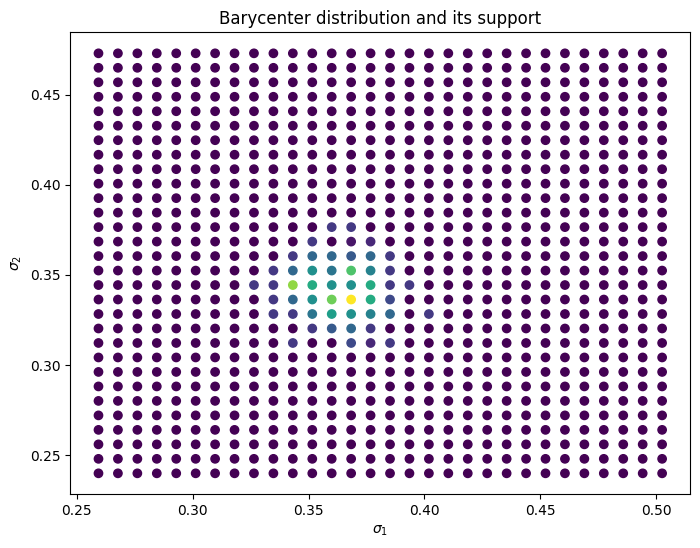

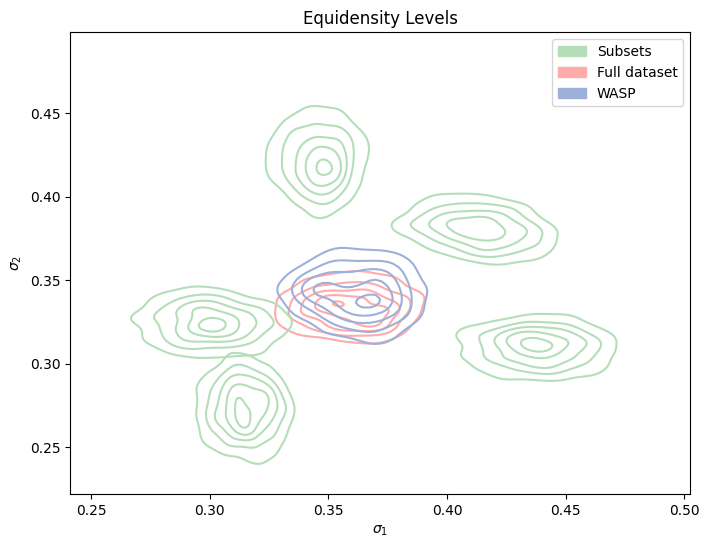

In [2]:
output = process_results('experience_1.yaml', proj='rho_1', npart=5)

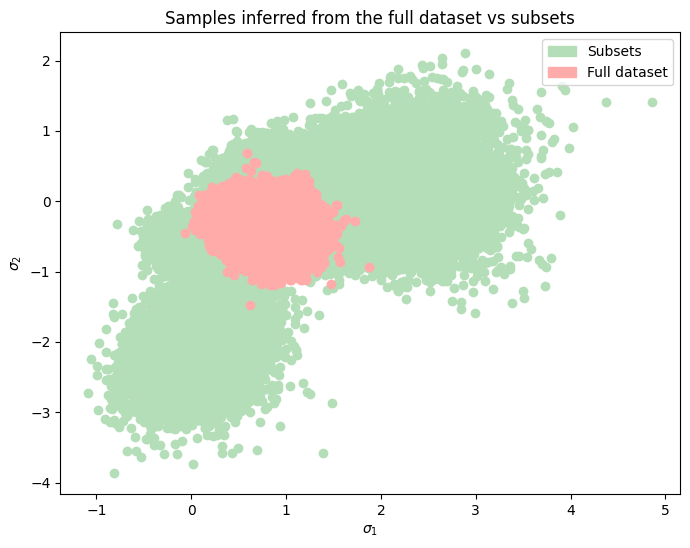

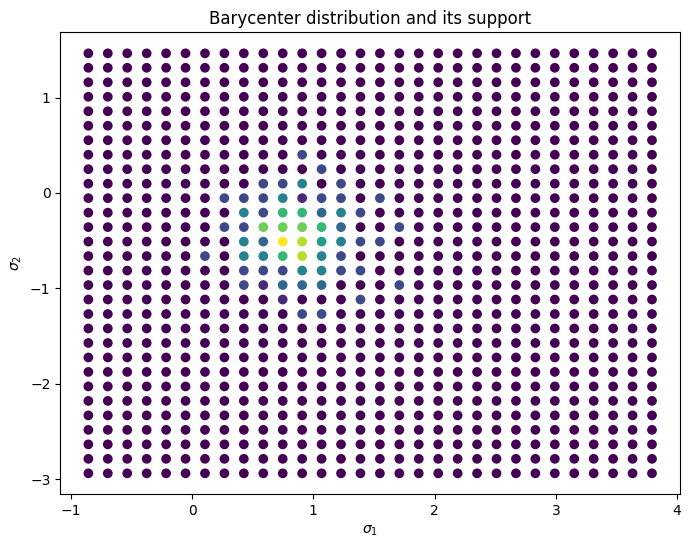

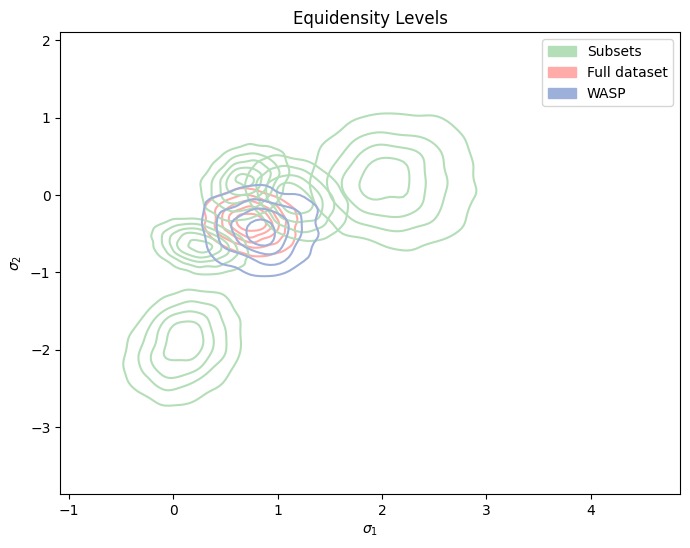

In [3]:
output = process_results('experience_logistic_regression.yaml', proj='identity_log', npart=5)

In [9]:
x_sub_sampling = output['subsampling']
full_data_sampling = output['full data sampling']
f = output['projection']

In [17]:
x_f_m = []
for sub_sampling in x_sub_sampling:
    x_f_m.append(f(sub_sampling))    
f_m = f(full_data_sampling)
x_f_m = np.array(x_f_m)

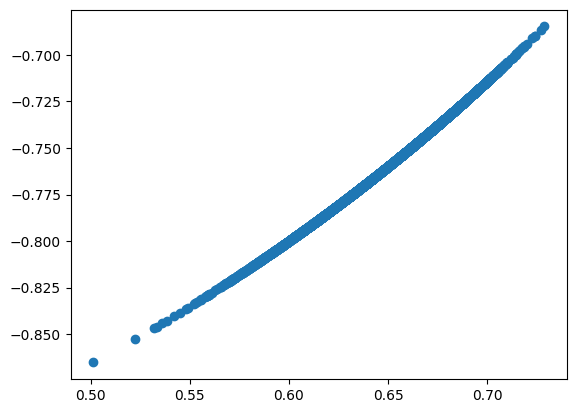

In [22]:
plt.scatter(x, y)

In [25]:
print(y.dtype)

float64


In [30]:
y.dropna(inplace=True) 

AttributeError: 'numpy.ndarray' object has no attribute 'dropna'

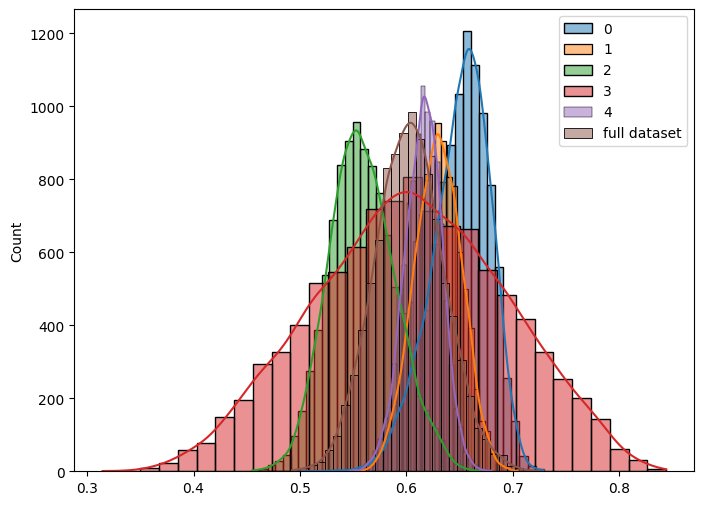

In [48]:
plt.figure(figsize=(8, 6))

for i in range(5):
    x = x_f_m[i, :, 0] # X-coordinates
    y = x_f_m[i, :, 1] # Y-coordinates

    sns.histplot(x, bins=30, kde=True, label=i)
    
    # Right histogram (Y-axis projection)
    #ax_histy = ax[1][1]
    #sns.histplot(y, bins=30, kde=True, ax=ax_histy, orientation='horizontal')
    #ax_histy.set(xlabel='Density', ylabel='', yticklabels=[])

x = f_m[:, 0]
y = f_m[:, 1]
sns.histplot(x, bins=30, kde=True, label='full dataset')

plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(8, 6))

for i in range(5):
    x = x_f_m[i, :, 0] # X-coordinates
    y = x_f_m[i, :, 1] # Y-coordinates

    sns.histplot(x, bins=30, kde=True, label=i)
    
    # Right histogram (Y-axis projection)
    #ax_histy = ax[1][1]
    #sns.histplot(y, bins=30, kde=True, ax=ax_histy, orientation='horizontal')
    #ax_histy.set(xlabel='Density', ylabel='', yticklabels=[])

x = f_m[:, 0]
y = f_m[:, 1]
sns.histplot(x, bins=30, kde=True, label='full dataset')

plt.legend()
plt.show()

In [37]:
has_nan = np.isinf(y).any()


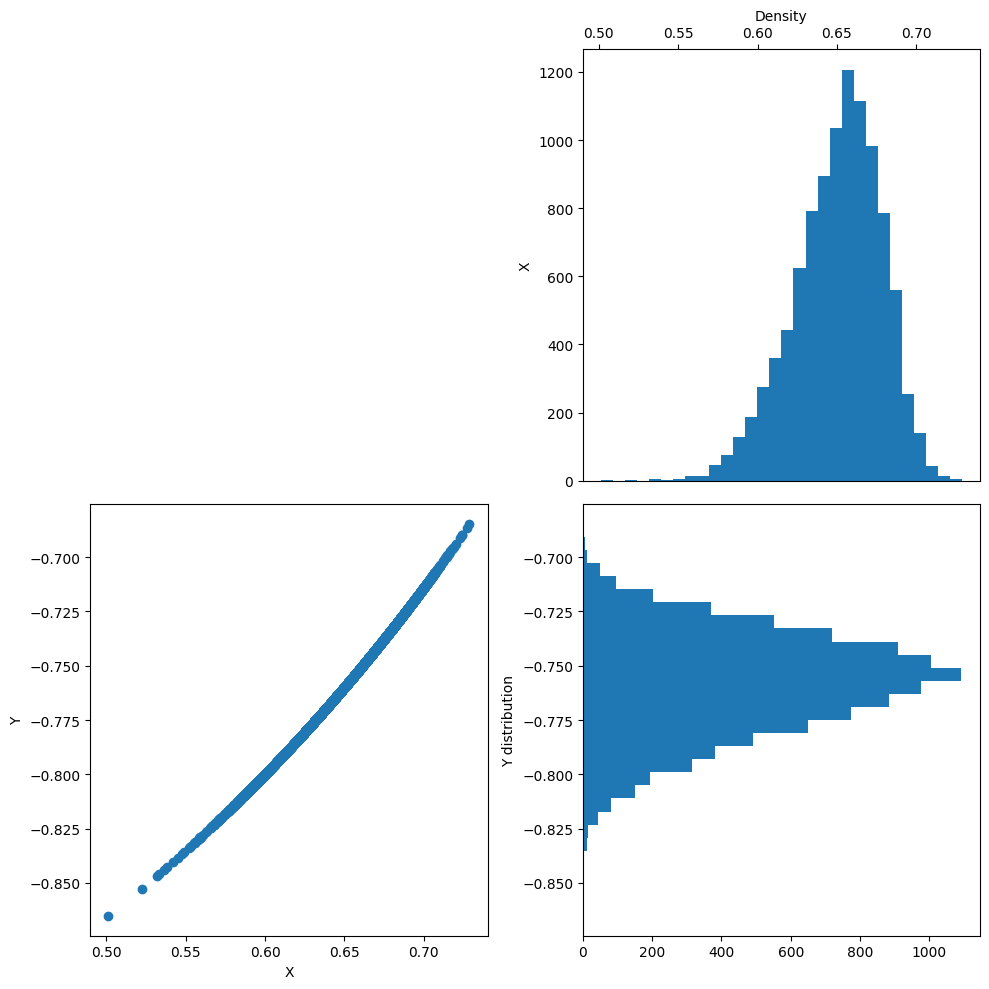

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Hide the top left subplot (to leave space for the main scatter plot)
axs[0, 0].axis('off')

# Main scatter plot on the bottom left
axs[1, 0].scatter(x, y)
axs[1, 0].set(xlabel='X', ylabel='Y')

# Histogram for the x distribution on top right
axs[0, 1].hist(x, bins=30, orientation='vertical')
axs[0, 1].set(xlabel='X distribution')

# Rotate the x distribution plot to align with the scatter plot
axs[0, 1].set(xlabel='Density', ylabel='X')
axs[0, 1].xaxis.tick_top()
axs[0, 1].xaxis.set_label_position('top') 

# Histogram for the y distribution on bottom right
axs[1, 1].hist(y, bins=30, orientation='horizontal')
axs[1, 1].set(ylabel='Y distribution')

# Adjust layout
plt.tight_layout()

### KMeans performances

TypeError: the dtypes of parameters y (object) and height (float64) are incompatible

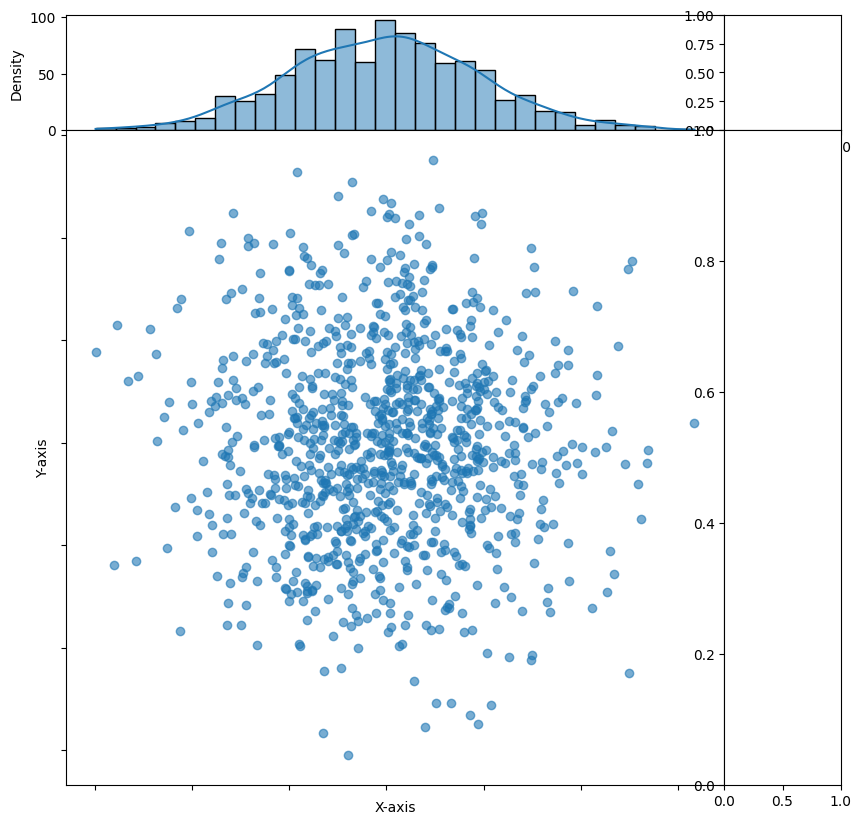

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example data: Generate some random points in R^2
np.random.seed(0) # For reproducibility
points = np.random.randn(1000, 2) # 1000 points in R^2

x = points[:, 0] # X-coordinates
y = points[:, 1] # Y-coordinates

# Create a figure with subplots
fig, ax = plt.subplots(2, 2, figsize=(10, 10),
                       gridspec_kw={"height_ratios": (.15, .85),
                                    "width_ratios": (.85, .15),
                                    "hspace": 0, "wspace": 0})

# Main scatter plot
ax_main = ax[1][0]
ax_main.scatter(x, y, alpha=0.6)
ax_main.set(xticklabels=[], yticklabels=[], xlabel='X-axis', ylabel='Y-axis')

# Top histogram (X-axis projection)
ax_histx = ax[0][0]
sns.histplot(x, bins=30, kde=True, ax=ax_histx)
ax_histx.set(xlabel='', ylabel='Density', xticklabels=[])

# Right histogram (Y-axis projection)
ax_histy = ax[1][1]
sns.histplot(y, bins=30, kde=True, ax=ax_histy, orientation='horizontal')
ax_histy.set(xlabel='Density', ylabel='', yticklabels=[])

# Remove spines of the histograms
for ax in [ax_histx, ax_histy]:
    sns.despine(ax=ax)

plt.show()
